## Importing Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from hazm import *
import nltk
from perke.unsupervised.graph_based import *
from yake import *
from sklearn.metrics.pairwise import cosine_similarity

## Loading Data

In [13]:
df = pd.read_json('Text.txt', lines=True).drop('id', axis=1)

In [15]:
df.head()

,body,keywords
0,این نوشتار بر آن است تا با بررسی فقه الحدیثی ک...,"[فقه الحدیث, معانی الاخبار, روش فقه الحدیثی, چ..."
1,چکیده: این پژوهش براساس چارچوب نظری ...,"[سید محمد خاتمی, آدریان لفت ویچ, پیتر ایوانز, ..."
2,فهم معانی عمیق و تدبر در آیات قرآن کریم برای ب...,"[جایگاه آرائ تفسیری, محمد یزدی, ترجمه قرآن]"
3,آزادی موهبتی است الهی که خدای متعال به انسان ع...,"[محدودیت بازدارنده, آزادی بیان, بدعت, دین, ارت..."
4,یکی از نکاتی که توجه پژوهشگران اندیشه‌های سیاس...,"[آزادی, محمد تقی مصباح یزدی, مرتضی مطهری, دموک..."


## PreProcessing

#### replace half space with complete space

In [16]:
for row, kps in enumerate(df.keywords):
    for index, kp in enumerate(kps):
        kp = kp.replace("\u200c", " ")
        df.keywords.iloc[row][index] = kp

#### remove duplicates in keywords

In [17]:
not_duplicate_keyphrases = list(df.keywords.copy())
for index, kps in enumerate(df.keywords):
    for kp in kps:
        if kps.count(kp) > 1:
            not_duplicate_keyphrases[index].remove(kp)
df.keywords = not_duplicate_keyphrases

In [18]:
df['other_keywords'] = [[] for i in range(len(df))]
df['true_keywords'] = [[] for i in range(len(df))]

kw_vect = CountVectorizer(ngram_range=(1, 10))

for index, kw in enumerate(df.keywords):
    sentence = df.body.iloc[index]
    sentence_ngrams = kw_vect.fit([sentence])
    sentence_features = kw_vect.get_feature_names_out()
    for k in kw:
        if k in sentence_features:
            df['true_keywords'].iloc[index].append(k)
        else:
            df['other_keywords'].iloc[index].append(k)

df['keywords'] = df['true_keywords']
df.drop('true_keywords', axis=1, inplace=True)

In [19]:
key_words_OOT = []
key_words_IOT = []

for index, keyword in enumerate(df.keywords):
    txt = df.iloc[index]['body']
    key_words_OOT_tmp = []
    key_words_IOT_tmp = []

    for kw in keyword:
        if kw in txt:
            key_words_IOT_tmp.append(kw)

        else:
            key_words_OOT_tmp.append(kw)

    key_words_OOT_tmp.append(key_words_OOT_tmp)
    key_words_IOT.append(key_words_IOT_tmp)

In [20]:
tokenizer = WordTokenizer(replace_links=True,
                          replace_emails=True, replace_numbers=True, replace_hashtags=True, )

In [21]:
from collections import Counter

df['normalized'] = None
df['tokenized'] = None
df['sticked_tokenized'] = None

normalizer = Normalizer()
inf_normalizer = InformalNormalizer(seperation_flag=True)

for index in range(len(df)):
    text = df.iloc[index]['body']
    text = text.replace("\u200c", " ")
    text = normalizer.normalize(text)

    df['normalized'][index] = text

    text = tokenizer.tokenize(text)
    df['tokenized'][index] = text
    df['sticked_tokenized'][index] = " ".join(text)

### Metrics

In [51]:
def f1_score(precision, recall):
    return 2*precision*recall/(precision + recall + 0.000001)

In [52]:
def text_metrics(preds, trues):
    tp = 0
    fp = 0
    fn = 0
    
    for index, pred in enumerate(preds):
        true = trues[index]

        for phrase in pred:
            if phrase in true:
                tp += 1
            else:
                fp += 1
                
        for phrase in true:
            if phrase not in pred:
                fn += 1

    prec = tp / (tp+fp+0.000001)
    rec = tp / (tp+fn+0.000001)
    f1 = f1_score(prec, rec)

    return prec, rec, f1

### Filters

#### Filter 1: remove KeyPhrases Longer than 3 Words

In [24]:
def filter1(preds):
    final_preds = []
    for index, pred in enumerate(preds):

        final_preds.append(pred.copy())
        for kp in pred:
            length = len(kp.split())
            if length > 3:
                final_preds[index].remove(kp)

    return final_preds

#### Filter 2: Mixing One Words

In [25]:
def return_one_words(pred):
    ones = []
    for kp in pred:
        if len(kp.split()) == 1:
            ones.append(kp)
    return ones

def mix_ones(ones):
    output = {}

    if len(ones) > 1:
        for index, word1 in enumerate(ones):
            for word2 in ones:
                if word1 != word2:
                    output[word1 + " " + word2] = [word1, word2]

    else:
        output = {None:None}
    return output

In [26]:
def filter2(preds, text_ngrams, word2score, threshold=0.45):
    output_preds = []
    for index, pred in enumerate(preds):
        output_preds.append(pred.copy())
        ones = return_one_words(pred)
        mixed = mix_ones(ones)
        
        for key in mixed.keys():

            if key in text_ngrams[index]:
                word1 = mixed[key][0]
                word2 = mixed[key][1]
                try:
                    word1_score = word2score[word1]
                    word2_score = word2score[word2]
                    candidate_score = word2score[key]
                    
                    mean_score = threshold * (word1_score + word2_score)
                    if candidate_score >= mean_score:
                        # print(key)
                        try:
                            output_preds[index].remove(word1)
                            output_preds[index].remove(word2)
                            pass
                        except:
                            pass

                        if key not in output_preds[index]:
                            output_preds[index].append(key)

                except:
                    pass

    return output_preds

#### Filter 3: KeyPhrase Subsets Remove

In [54]:
def filter3(preds, word2score):
    output_preds = []
    for index, pred in enumerate(preds):
        output_preds.append(pred.copy())
        for small_kp in pred:
            small_words = small_kp.split()
            for big_kp in pred:
                big_words = big_kp.split()
            
                if len(small_words) < len(big_words):
                    vectorizer = CountVectorizer(ngram_range=(1, len(big_words)))
                    vectorizer.fit([big_kp])
                    big_ngrams = vectorizer.get_feature_names_out()
                    if small_kp in big_ngrams:
                        try:
                            small_score = word2score[small_kp]
                            big_score = word2score[big_kp]
                            remove_small = False
                            remove_big = False

                            if len(small_words) == 2:
                                if small_score > 4*big_score:
                                    remove_big = True
                                
                                elif small_score < 1.8*big_score:
                                    remove_small = True
                            
                            else:

                                if small_score*0.6 <= big_score:
                                    remove_small = True


                                elif small_score > 4.2*big_score:
                                
                                    remove_big = True
                                    
                            if remove_small:
                                output_preds[index].remove(small_kp)
                            if remove_big:
                                output_preds[index].remove(big_kp)
                        except:
                            pass

    return output_preds

#### Filter 4: mixing two words

In [28]:
def return_two_words(pred):
    twos = []
    for kp in pred:
        if len(kp.split()) == 2:
            twos.append(kp)
    return twos

def mix_twos(twos):
    output = {}

    if len(twos) > 1:
        for index, word1 in enumerate(twos):
            for word2 in twos:
                if word1 != word2:
                    if word1.split()[1] == word2.split()[0]:
                        output[word1 + " " + word2.split()[1]] = [word1, word2]

    else:
        output = {None:None}
    return output

In [29]:
def filter4(preds, text_ngrams, word2score, threshold=0.45):
    output_preds = []
    for index, pred in enumerate(preds):
        output_preds.append(pred.copy())
        twos = return_two_words(pred)
        mixed = mix_twos(twos)
        for key, value in mixed.items():

            try:
                word1 = value[0]
                word2 = value[1]
                word1_score = word2score[word1]
                word2_score = word2score[word2]
                mean_score = threshold * (word1_score + word2_score)
                candidate_score = word2score[key]
                if candidate_score >= mean_score:
                    # print(key)
                    try:
                        output_preds[index].remove(word1)
                        output_preds[index].remove(word2)
                        pass
                    except:
                        pass

                    if key not in output_preds[index]:
                        output_preds[index].append(key)

            except:
                pass
    return output_preds

## TF-IDF BaseLine

In [30]:
def choose_keywords(sentences_scoreVec, features, threshold):
    df_keywords = []
    for vector in sentences_scoreVec:
        sentence_keywords = []
        idx_score = list(enumerate(vector))
        for tople in idx_score:
            idx = tople[0]
            score = tople[1]
            if score > threshold:
                sentence_keywords.append((idx, features[idx]))

        df_keywords.append(sentence_keywords)

    return df_keywords

In [31]:
tfidf = TfidfVectorizer(stop_words=utils.stopwords_list(), ngram_range=(1, 5))
tfidf_scores = tfidf.fit_transform(df.sticked_tokenized).toarray()
features = tfidf.get_feature_names_out()

word2score = {}
scores = tfidf_scores.max(axis=0)

for feature, index in tfidf.vocabulary_.items():
    score = scores[index]
    word2score[feature] = score

descrete_ngrams = []
for text in df.sticked_tokenized:
    tfidf.fit([text])
    ngrams = tfidf.get_feature_names_out()
    descrete_ngrams.append(ngrams)

e:\Apps\conda\envs\TensorFlow_GPU\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آید', 'توان', 'تواند', 'توانند', 'رسد', 'رود', 'سال', 'نمی', 'های', 'گوید', 'گویند'] not in stop_words.
  warnings.warn(


In [36]:
threshold = 0.07
precisions = []
recalls = []
f1_scores = []
keywords = df.keywords

for i in range(5):
    pred_keywords = choose_keywords(tfidf_scores, features, threshold)
    
    epoch_precision = []
    epoch_recall = []
    epoch_f1_score = []

    for idx, sentence_KW in enumerate(pred_keywords):
        kw_words = [s[1] for s in sentence_KW]

        true_positive = 0
        false_positive = 0
        false_negative = 0

        true_kw = keywords[idx]
        total_count = len(true_kw)

        for kw in kw_words:
            if kw in true_kw:
                true_positive += 1
            else:
                false_positive += 1

        for t_kw in true_kw:
            if t_kw not in kw_words:
                false_negative += 1

        precision = true_positive / (true_positive + false_positive + 0.0001)
        recall = true_positive / (true_positive + false_negative + 0.0001)
        f1_score = 2*precision*recall/(precision + recall + 0.0001)

        epoch_precision.append(precision)
        epoch_recall.append(recall)
        epoch_f1_score.append(f1_score)

    precisions.append(np.mean(epoch_precision))
    recalls.append(np.mean(epoch_recall))
    f1_scores.append(np.mean(epoch_f1_score))
    threshold += 0.01

# best threshold = 0.09 

In [ ]:
thresholds = np.linspace(7, 12, 5)/100
recalls = np.array(recalls)
precisions = np.array(precisions)
f1_scores = np.array(f1_scores)

plt.plot(thresholds, recalls*100, 'r', label='Recall')
plt.plot(thresholds, precisions*100, 'b', label='Precision')
plt.plot(thresholds, f1_scores*100, 'd--', label='F1_Score')

plt.grid(visible=True)
plt.ylabel('Percent')
plt.xlabel('Threshold')

leg = plt.legend()

## Singlerank

In [33]:
def Singlerank(texts, n):
    kp = []
    
    for text in texts:
        extractor = SingleRank()
        extractor.load_text(text, word_normalization_method=None)
        extractor.select_candidates()
        extractor.weight_candidates(normalize_weights=True, remove_redundants=True, window_size=10)

        keyphrases = extractor.get_n_best(n=n)

        keyphrases = [i[0] for i in keyphrases]
        kp.append(keyphrases)

    return kp

In [ ]:
precisions = []
recalls = []
f1_scores = []
trues = df.keywords

for n in range(5, 20):
    key_phrases = Singlerank(df.normalized[:20], n)

    prec, rec, f1 = text_metrics(key_phrases, trues)
    
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

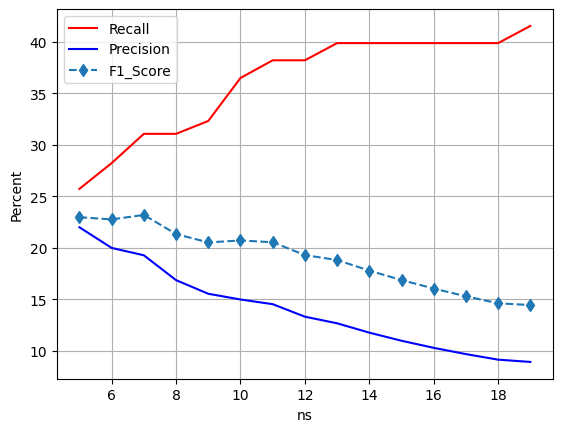

In [ ]:
ns = np.linspace(5, 19, 15)
recalls = np.array(recalls)
precisions = np.array(precisions)
f1_scores = np.array(f1_scores)

plt.plot(ns, recalls*100, 'r', label='Recall')
plt.plot(ns, precisions*100, 'b', label='Precision')
plt.plot(ns, f1_scores*100, 'd--', label='F1_Score')

plt.grid(visible=True)
plt.ylabel('Percent')
plt.xlabel('ns')

leg = plt.legend()

## Textrank

In [57]:
def Textrank(texts, n):
    kp = []
    
    for text in texts:
        extractor = TextRank()
        extractor.load_text(text, word_normalization_method=None)
        extractor.select_candidates()
        extractor.weight_candidates(normalize_weights=True, window_size=10)

        keyphrases = extractor.get_n_best(n=n)
        keyphrases = [i[0] for i in keyphrases]
        kp.append(keyphrases)

    return kp

In [ ]:
precisions = []
recalls = []
f1_scores = []
trues = df.keywords

for n in range(5, 20):
    key_phrases = Textrank(df.normalized[:20], n)

    prec, rec, f1 = text_metrics(key_phrases, trues)
    
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

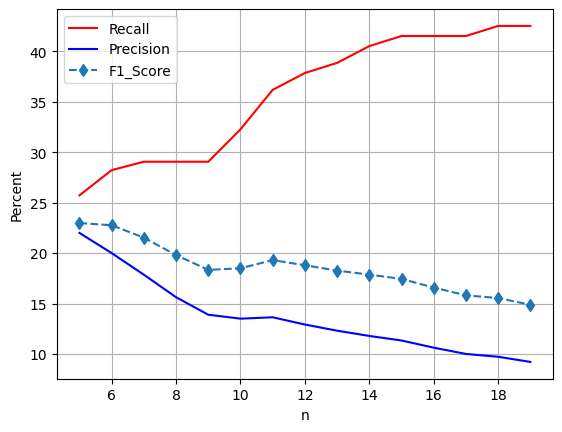

In [ ]:
ns = np.linspace(5, 19, 15)
recalls = np.array(recalls)
precisions = np.array(precisions)
f1_scores = np.array(f1_scores)

plt.plot(ns, recalls*100, 'r', label='Recall')
plt.plot(ns, precisions*100, 'b', label='Precision')
plt.plot(ns, f1_scores*100, 'd--', label='F1_Score')

plt.grid(visible=True)
plt.ylabel('Percent')
plt.xlabel('n')

leg = plt.legend()

## Position Rank

In [58]:
def Positionrank(texts, n):
    valid_pos_tags = {'NOUN', 'NOUN,EZ', 'ADJ', 'ADJ,EZ'}
    # valid_pos_tags = {'NOUN', 'ADJ'}
    grammar = r"""
        NP:
            {<NOUN>}<VERB>
        NP:
            {<DET(,EZ)?|NOUN(,EZ)?|NUM(,EZ)?|ADJ(,EZ)|PRON><DET(,EZ)|NOUN(,EZ)|NUM(,EZ)|ADJ(,EZ)|PRON>*}
            <NOUN>}{<.*(,EZ)?>
    """

    # grammar = r"""
    #         NP:
    #                 {<NOUN,EZ>?<NOUN.*>}    # Noun(s) + Noun(optional)
             
    #         NP:
    #                 {<NOUN.*><ADJ.*>}    # Noun(s) + Adjective(optional)
    #         """
    kp = []
    for text in texts:
        extractor = PositionRank(valid_pos_tags=valid_pos_tags)
        extractor.load_text(input=text, word_normalization_method=None)
        extractor.select_candidates(grammar=grammar, maximum_word_number=4)
        # extractor.select_candidates(maximum_word_number=4)
        extractor.weight_candidates(normalize_weights=True)

        keyphrases = extractor.get_n_best(n=n)
        # print(keyphrases)
        keyphrases = [i[0] for i in keyphrases]
        kp.append(keyphrases)

    return kp

In [35]:
precisions = []
recalls = []
f1_scores = []
trues = df.keywords

for n in range(4, 8):
    key_phrases = Positionrank(df.normalized[:20], n)

    prec, rec, f1 = text_metrics(key_phrases, trues)
    
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

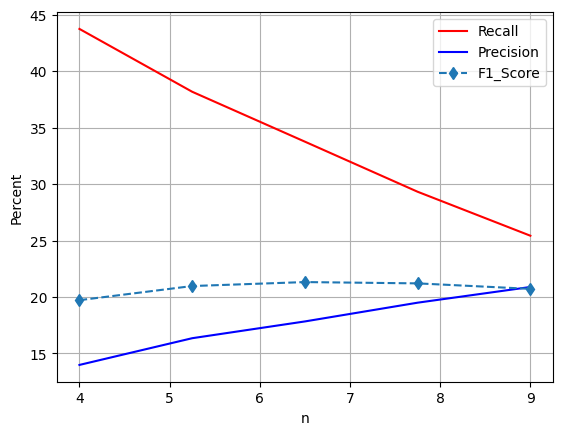

In [59]:
ns = np.linspace(4, 9, 5)
recalls = np.array(recalls)
precisions = np.array(precisions)
f1_scores = np.array(f1_scores)

plt.plot(ns, recalls*100, 'r', label='Recall')
plt.plot(ns, precisions*100, 'b', label='Precision')
plt.plot(ns, f1_scores*100, 'd--', label='F1_Score')

plt.grid(visible=True)
plt.ylabel('Percent')
plt.xlabel('n')

leg = plt.legend()

## Topic Rank

In [60]:
def Topicrank(texts, n):
    kp = []
    
    for text in texts:
        extractor = TopicRank()
        extractor.load_text(text, word_normalization_method=None)
        extractor.select_candidates()
        extractor.weight_candidates()

        keyphrases = extractor.get_n_best(n=n)

        keyphrases = [i[0] for i in keyphrases]
        kp.append(keyphrases)

    return kp

In [ ]:
precisions = []
recalls = []
f1_scores = []
trues = df.keywords

n = 3

for i in range(4):
    key_phrases = Topicrank(df.normalized[:20], n)

    prec, rec, f1 = text_metrics(key_phrases, trues)
    
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

    n += 1

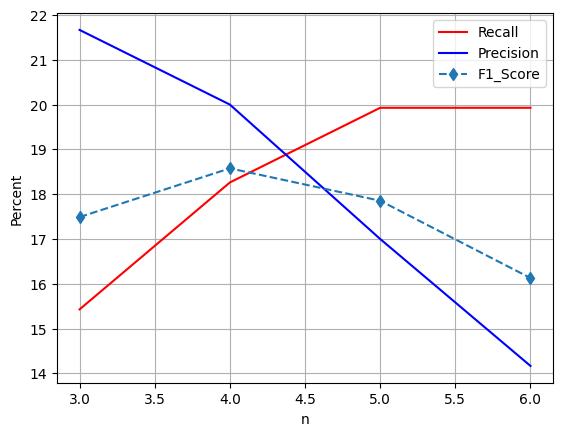

In [ ]:
ns = np.linspace(3, 6, 4)
recalls = np.array(recalls)
precisions = np.array(precisions)
f1_scores = np.array(f1_scores)

plt.plot(ns, recalls*100, 'r', label='Recall')
plt.plot(ns, precisions*100, 'b', label='Precision')
plt.plot(ns, f1_scores*100, 'd--', label='F1_Score')

plt.grid(visible=True)
plt.ylabel('Percent')
plt.xlabel('n')

leg = plt.legend()

## Multi Partite Rank

In [61]:
def multiPartiteRank(texts, n):
    valid_pos_tags = {'NOUN', 'ADJ'}
    
    kp = []
    
    for text in texts:
        extractor = MultipartiteRank(valid_pos_tags=valid_pos_tags)
        extractor.load_text(text, word_normalization_method=None)
        extractor.select_candidates()

        # extractor.weight_candidates()
        extractor.weight_candidates(
        threshold=0.74,
        metric='jaccard',
        linkage_method='average',
        alpha=1.1,
        )

        keyphrases = extractor.get_n_best(n=n)

        keyphrases = [i[0] for i in keyphrases]
        kp.append(keyphrases)

    return kp


In [ ]:
precisions = []
recalls = []
f1_scores = []
trues = df.keywords

for n in range(4, 10):
    key_phrases = multiPartiteRank(df.normalized[:20], n)

    prec, rec, f1 = text_metrics(key_phrases, trues)
    
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)


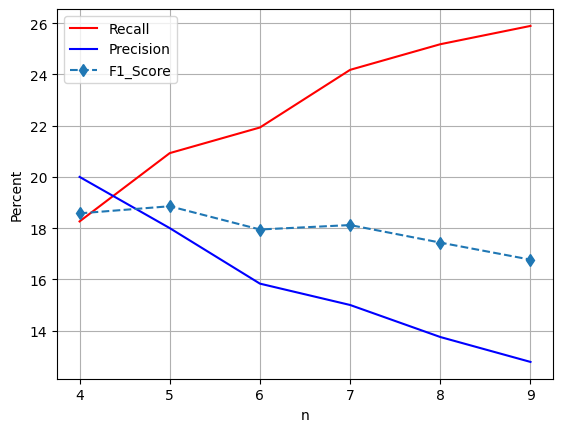

In [ ]:
ns = np.linspace(4, 9, 6)
recalls = np.array(recalls)
precisions = np.array(precisions)
f1_scores = np.array(f1_scores)

plt.plot(ns, recalls*100, 'r', label='Recall')
plt.plot(ns, precisions*100, 'b', label='Precision')
plt.plot(ns, f1_scores*100, 'd--', label='F1_Score')

plt.grid(visible=True)
plt.ylabel('Percent')
plt.xlabel('n')

leg = plt.legend()

## YAKE!

In [62]:
# best params: n=7, dedupLim=no matter, 
def yake(texts, n=7):
	all_keywords = []	

	for text in texts:
		kw_extractor = KeywordExtractor(n=3, dedupLim=0.4, features=None, lan="fa")
		keywords = kw_extractor.extract_keywords(text)
		keywords = [kw[0] for kw in keywords[:n]]
		all_keywords.append(keywords)

	return all_keywords

In [ ]:
trues = df.keywords

precisions = []
recalls = []
f1_scores = []

kw = yake(df.normalized)
prec, rec, f1 = text_metrics(kw, trues)

precisions.append(prec)
recalls.append(rec)
f1_scores.append(f1)
    

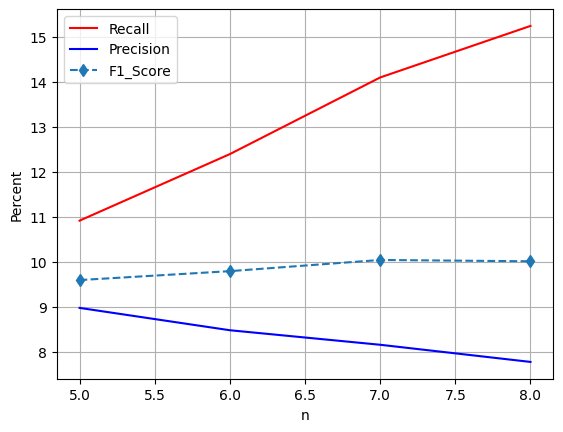

In [ ]:
ns = np.linspace(5, 8, 4)
recalls = np.array(recalls)
precisions = np.array(precisions)
f1_scores = np.array(f1_scores)

plt.plot(ns, recalls*100, 'r', label='Recall')
plt.plot(ns, precisions*100, 'b', label='Precision')
plt.plot(ns, f1_scores*100, 'd--', label='F1_Score')

plt.grid(visible=True)
plt.ylabel('Percent')
plt.xlabel('n')

leg = plt.legend()

## SG Rank

In [63]:
# Not Implemented!

# import Algorithms
# txt = df.normalized.iloc[0]
# SGRank.sgrank([txt], 5)

## Embed Rank

In [64]:
def extract_candidates(tagged, grammer):    
    keyphrase_candidate = set()
    np_parser = nltk.RegexpParser(grammer)
    trees = np_parser.parse_sents(tagged)
    for tree in trees:
        for subtree in tree.subtrees(filter=lambda t: t.label() == 'NP'):  # For each nounphrase
            keyphrase_candidate.add(' '.join(word for word, tag in subtree.leaves()))
    keyphrase_candidate = {kp for kp in keyphrase_candidate if len(kp.split()) <= 5}
    keyphrase_candidate = list(keyphrase_candidate)
    return keyphrase_candidate

In [65]:
model_path = 'Models\pos_tagger.model'
tagger = POSTagger(model = model_path)
token_tag_list = []
for text_tokens in df.tokenized:
    posed = tagger.tag_sents([text_tokens])
    token_tag_list.append(posed)

In [66]:
grammers = [
            """
            NP:
                    {<NOUN,EZ>?<NOUN.*>}    # Noun(s) + Noun(optional)
            """ ,

            """
            NP:
                    {<NOUN.*><ADJ.*>}    # Noun(s) + Adjective(optional)
            """]

all_candidates1 = []

for token_tag in token_tag_list:
        temp_candidate = extract_candidates(token_tag, grammers[0])
        temp_candidate += extract_candidates(token_tag, grammers[1])
        all_candidates1.append(np.array(temp_candidate))


In [67]:
sent2vec_model_path = 'Models\sent2vec-naab.model'
sent2vec_model = SentEmbedding(sent2vec_model_path)

In [68]:
all_candidates_vectors = []
for keyPhrases in all_candidates1:
    candidadte_vec = np.asarray([sent2vec_model[candidate] for candidate in keyPhrases])
    all_candidates_vectors.append(candidadte_vec)

In [69]:
all_sentences_vectors = []
for txt in df.normalized:
    sentence_vectorized = sent2vec_model[txt]
    all_sentences_vectors.append(sentence_vectorized)

In [70]:
all_candidate_sim_candidate = []
for candidate in all_candidates_vectors:
    candidate_sim_candidate = cosine_similarity(candidate)
    all_candidate_sim_candidate.append(candidate_sim_candidate)

In [71]:
all_candidates_sim_whole = []
for i in range(450):
    text_embeding = all_sentences_vectors[i]
    candidate_embeddings = all_candidates_vectors[i]
    
    similarity = cosine_similarity(candidate_embeddings, text_embeding.reshape(1,-1))
    similarity = similarity.reshape(1,-1)
    all_candidates_sim_whole.append(similarity)

In [72]:
for index, candidates_sim_whole in enumerate(all_candidates_sim_whole):
    
    candidates_sim_whole_norm = candidates_sim_whole / np.max(candidates_sim_whole)
    candidates_sim_whole_norm = 0.5 + (candidates_sim_whole_norm - np.average(candidates_sim_whole_norm)) / np.std(candidates_sim_whole_norm)
    all_candidates_sim_whole[index] = candidates_sim_whole_norm[0]

In [73]:
for index, candidate_sim_candidate in enumerate(all_candidate_sim_candidate):
    
    np.fill_diagonal(candidate_sim_candidate, np.NaN)
    candidate_sim_candidate_norm = candidate_sim_candidate / np.nanmax(candidate_sim_candidate, axis=0)
    candidate_sim_candidate_norm = 0.5 + (candidate_sim_candidate_norm - np.nanmean(candidate_sim_candidate_norm, axis=0)) / np.nanstd(candidate_sim_candidate_norm, axis=0)
    all_candidate_sim_candidate[index] = candidate_sim_candidate_norm

In [74]:
from operator import itemgetter 
beta = 0.82
keyword_count = 5
kp_preds = []

for index in range(450):
    candidates = all_candidates1[index]
    N = min(len(candidates), keyword_count)

    selected_candidates = []
    unselected_candidates = [i for i in range(len(candidates))]
    best_candidate = np.argmax(all_candidates_sim_whole[index])
    selected_candidates.append(best_candidate)
    unselected_candidates.remove(best_candidate)


    for i in range(N-1):
        selected_vec = np.array(selected_candidates)
        unselected_vec = np.array(unselected_candidates)
    
        unselected_candidate_sim_whole = all_candidates_sim_whole[index][unselected_vec]

        dist_between = all_candidate_sim_candidate[index][unselected_vec]

        if dist_between.ndim == 1:
            print('if runed')
            dist_between = dist_between[:, np.newaxis]

        best_candidate = np.argmax(beta * unselected_candidate_sim_whole - (1 - beta) * np.nanmax(dist_between, axis = 1))
        best_index = unselected_candidates[best_candidate]
        

        selected_candidates.append(best_index)
        unselected_candidates.remove(best_index)

    kp_pred = itemgetter(*selected_candidates)(all_candidates1[index])
    kp_preds.append(list(kp_pred))

In [75]:
prec, rec, f1 = text_metrics(kp_preds, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}") 

kp_preds1 = filter1(kp_preds)
prec, rec, f1 = text_metrics(kp_preds1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}") 

kp_preds1 = filter2(kp_preds, descrete_ngrams, word2score)
prec, rec, f1 = text_metrics(kp_preds1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}") 

kp_preds1 = filter3(kp_preds, word2score)
prec, rec, f1 = text_metrics(kp_preds1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}") 

Precision: 7.11 | Recall: 7.73 | F1-Score: 7.41
Precision: 7.11 | Recall: 7.73 | F1-Score: 7.41
Precision: 7.12 | Recall: 7.73 | F1-Score: 7.41
Precision: 7.20 | Recall: 7.44 | F1-Score: 7.32


## TF-idf with chunking, KP-Miner

#### Predict Function

In [ ]:
def candidate_score(features, tfidf_scores, candidates):
    chunk_indexes = []
    chunk_features = []
    chunk_scores = []
    feature_score = []
    
    for i in range(450):
        tmp_indexes = []
        tmp_features = []
        tmp_scores = []

        for index, feature in enumerate(features):
            if feature in candidates[i]:
                tmp_indexes.append(index)
                tmp_features.append(feature)
                score = tfidf_scores[i][index]
                score = increment_score(feature, score)
                tmp_scores.append(score)

        chunk_indexes.append(tmp_indexes)
        chunk_features.append(tmp_features)
        chunk_scores.append(tmp_scores)

    for i in range(len(chunk_features)):
        tmp = []
        for feature, score in zip(chunk_features[i], chunk_scores[i]):
            tmp.append((feature, score))

        feature_score.append(sorted(tmp, key=lambda x : x[1], reverse=True))
    
    return feature_score

In [ ]:
def add_NE(name_entities, preds):
    for index, name_entity_lst in enumerate(name_entities):
        for name_entity in name_entity_lst:
            if name_entity not in preds[index]:
                preds[index].append(name_entity)
    return preds

In [ ]:
def apply_filters(preds, descrete_ngrams, word2score):
    preds = filter1(preds)
    preds = filter2(preds, descrete_ngrams, word2score)
    preds = filter4(preds, descrete_ngrams, word2score, threshold=0.4)
    preds = filter3(preds, word2score)

    return preds

In [ ]:
def predict_with_threshold(feature_score, descrete_ngrams, word2score, name_entities, 
                            minimum=4, maximum=6, threshold=0.2):
    preds = []
    for pred in feature_score:
        tmp_pred = []
        for feature, score in pred:
            if score >= threshold:
                tmp_pred.append(feature)
        tmp_pred = apply_filters([tmp_pred], descrete_ngrams, word2score)[0]

        if len(tmp_pred) < minimum:
            tmp_pred = []
            for feature, _ in pred[:20]:
                tmp_pred.append(feature)
            tmp_pred = apply_filters([tmp_pred], descrete_ngrams, word2score)[0][:minimum]
            
        elif len(tmp_pred) > maximum:
            tmp_pred = []
            for feature, _ in pred[:40]:
                tmp_pred.append(feature)
            tmp_pred = apply_filters([tmp_pred], descrete_ngrams, word2score)[0][:maximum]

        preds.append(tmp_pred)
    preds = add_NE(name_entities, preds)
    preds = apply_filters(preds, descrete_ngrams, word2score)
    return preds

#### Increment Score Of words Base on length

In [ ]:
def increment_score(kp, score):
    length = len(kp.split())

    factor1 = 0.045
    factor2 = 0.12
    factor3 = 0.03

    if length == 1:
        score += factor1

    if length == 2:
        score += factor2

    if length == 3:
        score += factor3

    return score

### Making N_Grams

In [ ]:
tfidf = TfidfVectorizer(stop_words=utils.stopwords_list(), ngram_range=(1, 3))
tfidf_scores = tfidf.fit_transform(df.sticked_tokenized).toarray()
features = tfidf.get_feature_names_out()

e:\Apps\conda\envs\TensorFlow_GPU\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آید', 'توان', 'تواند', 'توانند', 'رسد', 'رود', 'سال', 'نمی', 'های', 'گوید', 'گویند'] not in stop_words.
  warnings.warn(


In [ ]:
word2score = {}
scores = tfidf_scores.max(axis=0)

for feature, index in tfidf.vocabulary_.items():
    score = scores[index]
    word2score[feature] = score

In [ ]:
descrete_ngrams = []
for text in df.sticked_tokenized:
    tfidf.fit([text])
    ngrams = tfidf.get_feature_names_out()
    descrete_ngrams.append(ngrams)

### Model

In [ ]:
model_path = 'Models\pos_tagger.model'
tagger = POSTagger(model = model_path)
token_tag_list = []
for text_tokens in df.tokenized:
    posed = tagger.tag_sents([text_tokens])
    token_tag_list.append(posed)

grammers = [
            """
            NP:
                    {<NOUN,EZ>?<NOUN.*>}    # Noun(s) + Noun(optional)
            """ ,

            """
            NP:
                    {<NOUN.*><ADJ.*>}    # Noun(s) + Adjective(optional)
            """]

all_candidates1 = []

for token_tag in token_tag_list:
        temp_candidate = extract_candidates(token_tag, grammers[0])
        temp_candidate += extract_candidates(token_tag, grammers[1])
        all_candidates1.append(np.array(temp_candidate))

### Predicting

#### With Threshold

In [ ]:
feature_score = candidate_score(features, tfidf_scores, all_candidates1)

In [ ]:
preds = predict_with_threshold(feature_score, descrete_ngrams, word2score, name_entities,
                                minimum=2, maximum=7, threshold=0.2015)

prec, rec, f1 = text_metrics(preds, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")     

Precision: 36.54 | Recall: 31.91 | F1-Score: 34.07


#### With N_Best

In [ ]:
preds = predict_with_threshold(feature_score, five_ngrams, word2score, name_entities, 
minimum=5, maximum=5, threshold=1)

prec, rec, f1 = text_metrics(preds, trues)
print(f"Precision: {prec}, Recall: {rec}, F1-Score: {f1}")     

Precision: 0.2845733500275018, Recall: 0.3273694389132643, F1-Score: 0.30447442922633805


### Test

In [496]:
print('True KeyPhrases From Sentences(130, 135)')
for index, i in enumerate(trues[130:135]):
    print(index+1, i)

print('-----------------------------------------------------------------------------------------------------------------------------------------')
print('Predicted KeyPhrases')
for index, i in enumerate(preds[130:135]):
    print(index+1, i)

True KeyPhrases From Sentences(130, 135)
1 ['مبانی تاریخ گذاری', 'تاریخ گذاری قرآن', 'بازرگان', 'روش آماری']
2 ['فلسفه انتقادی تاریخ', 'فلسفه نظری تاریخ', 'فلسفه تاریخ', 'تاریخ', 'مورخ']
3 ['حقوق زنان', 'تاریخی نگری', 'تاریخ', 'نقد', 'قرآن', 'احکام فقهی']
4 ['رشد اقتصادی', 'کشورهای منتخب', 'داده های تابلویی', 'تامین مالی اسلامی']
5 ['رویکرد تفکیک', 'رویکرد برابری', 'رویکرد خنثی', 'تبیین فلسفی', 'ملاحظات جنسیتی']
-----------------------------------------------------------------------------------------------------------------------------------------
Predicted KeyPhrases
1 ['قرآن کریم', 'نزول', 'بازرگان', 'تاریخ نزول', 'مبانی تاریخ']
2 ['فلسفه تاریخ', 'تاریخ']
3 ['زنان', 'مسائل فقهی', 'متون دینی', 'تاریخ مند', 'تاریخ مندانه', 'احکام فقهی']
4 ['تامین مالی', 'توسعه اقتصادی']
5 ['ملاحظات جنسیتی', 'رویکردهای ناظر', 'عدالت محور', 'مبانی فلسفی']


## Name Entity Recognition

In [38]:
from transformers import AutoTokenizer
from transformers import TFAutoModelForTokenClassification
from transformers import pipeline


model_name_or_path = "HooshvareLab/albert-fa-zwnj-base-v2-ner"  # Albert
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
model = TFAutoModelForTokenClassification.from_pretrained(model_name_or_path)

nlp = pipeline("ner", model=model, tokenizer=tokenizer)

All model checkpoint layers were used when initializing TFAlbertForTokenClassification.

All the layers of TFAlbertForTokenClassification were initialized from the model checkpoint at HooshvareLab/albert-fa-zwnj-base-v2-ner.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertForTokenClassification for predictions without further training.


#### NER Function for Whole corpus

In [39]:
def index2word(dicts):
    output = {}
    for dictionary in dicts:
        index = dictionary['index']
        word = dictionary['word']
        output[index] = word

    return output

In [40]:
def find_sequence(numbers):
    sequences = []
    index = 0
    while index < len(numbers)-1:
        sequence = []
        num1 = numbers[index]
        num2 = numbers[index+1]
        sequence.append(num1)
        
        while num2 == num1+1:
            sequence.append(num2)
            index += 1
            num1 = num2
            try:
                num2 = numbers[index+1]
            except:
                break
        if sequence!=[num1]:
            sequences.append(sequence)
            
        index += 1
        
    return sequences

In [41]:
def index_to_words(sequences, index2words, ngrams):
    all_ne = []
    for sequence in sequences:
        words = [index2words[index].replace("▁", "") for index in sequence]
        ne = " ".join(words)
        if ne in ngrams:
            all_ne.append(ne)
    return all_ne

In [42]:
def make_texts_dicts(corpus):
    all_dicts = []
    for text in corpus:
        all_dicts.append(nlp(text))

    return all_dicts

In [43]:
def chain_words(texts_dicts, descrete_ngrams):
    all_ne = []
    for index, text_dict in enumerate(texts_dicts):
        index2words = index2word(text_dict)
        tmp_indexes = []
        for dictionary in text_dict:
            tmp_indexes.append(dictionary['index'])
        tmp_indexes.sort()
        sequences = find_sequence(tmp_indexes)
        name_entities = index_to_words(sequences, index2words, descrete_ngrams[index])
        name_entities = list(set(name_entities))
        all_ne.append(name_entities)

    return all_ne

In [44]:
texts_dicts = make_texts_dicts(df.sticked_tokenized)
name_entities = chain_words(texts_dicts, descrete_ngrams)

## Models Comparison

In [49]:
trues = df.keywords

### Singlerank

In [46]:
key_phrases_sr = Singlerank(df.normalized, 7)

In [55]:
prec, rec, f1 = text_metrics(key_phrases_sr, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

key_phrases_sr1 = filter1(key_phrases_sr)
prec, rec, f1 = text_metrics(key_phrases_sr1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

key_phrases_sr1 = filter2(key_phrases_sr1, descrete_ngrams, word2score)
prec, rec, f1 = text_metrics(key_phrases_sr1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

key_phrases_sr1 = filter3(key_phrases_sr1, word2score)
prec, rec, f1 = text_metrics(key_phrases_sr1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

Precision: 15.59 | Recall: 23.74 | F1-Score: 18.82
Precision: 18.77 | Recall: 23.40 | F1-Score: 20.84
Precision: 18.88 | Recall: 23.40 | F1-Score: 20.90
Precision: 21.86 | Recall: 21.52 | F1-Score: 21.69


### TextRank

In [76]:
key_phrases_ter = Textrank(df.normalized, 5) 

In [77]:
prec, rec, f1 = text_metrics(key_phrases_ter, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   


key_phrases_ter1 = filter1(key_phrases_ter)
prec, rec, f1 = text_metrics(key_phrases_ter1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   


key_phrases_ter1 = filter2(key_phrases_ter1, descrete_ngrams, word2score)
prec, rec, f1 = text_metrics(key_phrases_ter1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

key_phrases_ter1 = filter3(key_phrases_ter1, word2score)
prec, rec, f1 = text_metrics(key_phrases_ter1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

Precision: 18.58 | Recall: 20.21 | F1-Score: 19.36
Precision: 20.93 | Recall: 20.02 | F1-Score: 20.46
Precision: 21.07 | Recall: 20.07 | F1-Score: 20.55
Precision: 24.13 | Recall: 18.81 | F1-Score: 21.14


### PositionRank

In [78]:
key_phrases_pr = Positionrank(df.normalized, 5) 

In [79]:
prec, rec, f1 = text_metrics(key_phrases_pr, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

key_phrases_pr1 = filter1(key_phrases_pr)
prec, rec, f1 = text_metrics(key_phrases_pr1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

key_phrases_pr1 = filter2(key_phrases_pr1, descrete_ngrams, word2score)
prec, rec, f1 = text_metrics(key_phrases_pr1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

key_phrases_pr1 = filter3(key_phrases_pr1, word2score)
prec, rec, f1 = text_metrics(key_phrases_pr1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

Precision: 5.96 | Recall: 6.48 | F1-Score: 6.21
Precision: 5.96 | Recall: 6.48 | F1-Score: 6.21
Precision: 8.04 | Recall: 8.27 | F1-Score: 8.15
Precision: 8.07 | Recall: 8.27 | F1-Score: 8.17


### TopicRank

In [80]:
key_phrases_tor = Topicrank(df.normalized, 4) 

In [81]:
prec, rec, f1 = text_metrics(key_phrases_tor, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

key_phrases_tor1 = filter1(key_phrases_tor)
prec, rec, f1 = text_metrics(key_phrases_tor1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

key_phrases_tor1 = filter2(key_phrases_tor1, descrete_ngrams, word2score)
prec, rec, f1 = text_metrics(key_phrases_tor1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

key_phrases_tor1 = filter3(key_phrases_tor1, word2score)
prec, rec, f1 = text_metrics(key_phrases_tor1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

Precision: 16.61 | Recall: 14.46 | F1-Score: 15.46
Precision: 17.97 | Recall: 14.41 | F1-Score: 16.00
Precision: 17.96 | Recall: 14.31 | F1-Score: 15.93
Precision: 17.98 | Recall: 14.26 | F1-Score: 15.91


### MultiPartiteRank

In [82]:
key_phrases_mr = multiPartiteRank(df.normalized, 5)

In [83]:
prec, rec, f1 = text_metrics(key_phrases_mr, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

key_phrases_mr1 = filter1(key_phrases_mr)
prec, rec, f1 = text_metrics(key_phrases_mr1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

key_phrases_mr1 = filter2(key_phrases_mr1, descrete_ngrams, word2score)
prec, rec, f1 = text_metrics(key_phrases_mr1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

key_phrases_mr1 = filter3(key_phrases_mr1, word2score)
prec, rec, f1 = text_metrics(key_phrases_mr1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

Precision: 15.69 | Recall: 17.07 | F1-Score: 16.35
Precision: 16.98 | Recall: 16.97 | F1-Score: 16.98
Precision: 17.06 | Recall: 16.97 | F1-Score: 17.02
Precision: 17.32 | Recall: 16.92 | F1-Score: 17.12


### yake

In [84]:
key_phrases_ya = yake(df.normalized)

In [88]:
prec, rec, f1 = text_metrics(key_phrases_ya, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

key_phrases_ya1 = filter2(key_phrases_ya, descrete_ngrams, word2score)
prec, rec, f1 = text_metrics(key_phrases_ya1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

key_phrases_ya1 = filter3(key_phrases_ya1, word2score)
prec, rec, f1 = text_metrics(key_phrases_ya1, trues)
print(f"Precision: {'{:.2f}'.format(prec*100)}\
 | Recall: {'{:.2f}'.format(rec*100)}\
 | F1-Score: {'{:.2f}'.format(f1*100)}")   

Precision: 8.44 | Recall: 12.86 | F1-Score: 10.20
Precision: 8.62 | Recall: 13.06 | F1-Score: 10.38
Precision: 8.64 | Recall: 12.52 | F1-Score: 10.22
